### Lab 3. Gradient descent methods

1. Implement:

    (a) Constant-step gradient descent;
    
    (b) Gradient descent with fractional steps (Armijo condition);
    
    (c) Steepest descent (using any two one-dimensional search methods);
    
    (d) Conjugate gradient method (with restart).
2. For the study, consider:

    (a) Well-conditioned (μ ≃1) two-dimensional quadratic function;
   
    (b) Ill-conditioned (μ > 10) two-dimensional quadratic function;
   
    (c) Rosenbrock function.
3. For each function:

    (a) Build a table that reflects the dependence of the number of iterations of the gradient method, the number of function calculations(if any), and the number of function gradient calculations (if any) for each of the methods on the chosen accuracy;
   
    (b) plot the data from the table (abscissa axis – accuracy, ordinate axis – number of iterations/function/gradient calculations);
4. For the Rosenbrock function, plot and compare the trajectories of each method on the level line plot.

5. Implement a generator of quadratic functions of a given dimension and condition number. Investigate the dependence of the number of iterations that must be performed to achieve the selected accuracy, depending on these parameters. Consider this dependence for two gradient methods, one of which is (necessarily) the conjugate gradient method.

#### 1

Implement:

(a) Constant-step gradient descent;

(b) Gradient descent with fractional steps (Armijo condition);

(c) Steepest descent (using any two one-dimensional search methods);

(d) Conjugate gradient method (with restart).

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

In [128]:
def grad(f: Callable[[np.ndarray], float], x: np.ndarray):
    Delta_f = np.zeros_like(x,dtype=float)
    for k in range(len(x)):
        dx = np.zeros_like(x,dtype=float)
        dx[k] = np.finfo(float).eps * 10
        # print(f(x + dx))
        Delta_f[k] = (f(x + dx) - f(x - dx)) / (2 * np.linalg.norm(dx))
    return Delta_f

In [129]:
# a
def gd_constant_step(
    f: Callable[[np.ndarray], np.ndarray], x0: np.ndarray, lr: float, maxit: int = 1000
) -> np.ndarray:
    x = x0
    for _ in range(maxit):
        x -= lr * grad(f, x)
    return x

In [130]:
# b
def gd_fractional_step(
    f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    lr: float,
    maxit: int = 1000,
    eps: float = np.finfo(float).eps * 10,
    lamb=0.5,
) -> np.ndarray:
    x = x0
    for _ in range(maxit):
        g = grad(f, x)
        if f(x) - f(x - lr * g) > eps * lr * np.linalg.norm(g)**2:
            x -= lr * g
        else:
            lr *= lamb
            x -= lr * g
    return x

In [131]:
def brent_search(
    f: Callable[[float], float], a: float, b: float, eps=1e-9, out_info=False
):
    iter_count, f_call_count = 1, 1
    if b < a:
        a, b = b, a
    K = (3 - 5**0.5) / 2
    x = w = v = (a + b) / 2
    fw = fv = fx = f(x)
    deltax = 0.0
    iter = 0
    maxiter = 1e9
    while iter < maxiter:
        iter += 1
        iter_count += 1

        mintol = eps / 4
        tol1 = eps * np.abs(x) + mintol
        tol2 = 2.0 * tol1
        xmid = 0.5 * (a + b)
        # check for convergence
        if np.abs(x - xmid) < (tol2 - 0.5 * (b - a)):
            break
        if np.abs(deltax) <= tol1:
            if x >= xmid:
                deltax = a - x  # do a golden section step
            else:
                deltax = b - x
            rat = K * deltax
        else:  # do a parabolic step
            tmp1 = (x - w) * (fx - fv)
            tmp2 = (x - v) * (fx - fw)
            p = (x - v) * tmp2 - (x - w) * tmp1
            tmp2 = 2.0 * (tmp2 - tmp1)
            if tmp2 > 0.0:
                p = -p
            tmp2 = np.abs(tmp2)
            dx_temp = deltax
            deltax = rat
            # determine whether a parabolic step is acceptable or not:
            if (
                (p > tmp2 * (a - x))
                and (p < tmp2 * (b - x))
                and (np.abs(p) < np.abs(0.5 * tmp2 * dx_temp))
            ):
                # whew, parabolic fit:
                rat = p * 1.0 / tmp2
                u = x + rat
                if (u - a) < tol2 or (b - u) < tol2:
                    if xmid - x >= 0:
                        rat = tol1
                    else:
                        rat = -tol1
            else:
                # nope, try golden section instead
                if x >= xmid:
                    deltax = a - x
                else:
                    deltax = b - x
                rat = K * deltax
        # update current position:
        if np.abs(rat) < tol1:  # update by at least tol1
            if rat >= 0:
                u = x + tol1
            else:
                u = x - tol1
        else:
            u = x + rat
        fu = f(u)
        f_call_count += 1
        if fu > fx:
            # Oh dear, point u is worse than what we have already,
            # even so it *must* be better than one of our endpoints:
            if u < x:
                a = u
            else:
                b = u

            if (fu <= fw) or (w == x):
                # however it is at least second best:
                v = w
                w = u
                fv = fw
                fw = fu
            elif (fu <= fv) or (v == x) or (v == w):
                # third best:
                v = u
                fv = fu
        else:
            # good new point is an improvement!
            # update brackets:
            if u >= x:
                a = x
            else:
                b = x
            # update control points:
            v = w
            w = x
            x = u
            fv = fw
            fw = fx
            fx = fu
    res = x
    if not out_info:
        return res
    else:
        return res, iter_count, f_call_count, b - a


In [132]:
def golden_section_search(
    f: Callable[[float], float], a: float, b: float, eps=1e-9, out_info=False
):
    iter_count, f_call_count = 0, 0
    if b < a:
        a, b = b, a
    # golden ratio
    gr = (5**0.5 - 1) / 2

    iter_count += 1
    f_call_count += 2
    x = b - (b - a) * gr
    y = a + (b - a) * gr
    fx = f(x)
    fy = f(y)
    while b - a > eps:
        iter_count += 1
        f_call_count += 1
        if fx < fy:
            b = y
            y = x
            fy = fx
            x = b - (b - a) * gr
            fx = f(x)
        else:
            a = x
            x = y
            fx = fy
            y = a + (b - a) * gr
            fy = f(y)

    res = (b + a) / 2
    if not out_info:
        return res
    else:
        return res, iter_count, f_call_count, b - a


In [133]:
# c
def steepest_descent(
    f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    max_lr: float,
    method: str = "golden_section",
    maxit: int = 1000,
    eps: float = np.finfo(float).eps * 10,
) -> np.ndarray:
    """golden_section search or brent_search"""

    if method == "golden_section":
        search_method = golden_section_search
    else:
        search_method = brent_search
    x = x0
    for _ in range(maxit):
        g = grad(f, x)
        lr = search_method(lambda y: f(x - y * g), 0, max_lr, eps=eps)
        x -= lr * g
    return x

In [134]:
# d
def conjugate_gradient(
    f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    max_lr: float,
    method: str = "golden_section",
    max_it: int = 1000,
    eps: float = np.finfo(float).eps * 10,
    max_subit: int = None,
) -> np.ndarray:
    """golden_section search or brent_search"""
    if max_subit is None:
        max_subit = len(x0)
    if method == "golden_section":
        search_method = golden_section_search
    else:
        search_method = brent_search
    x = x0
    for _ in range(max_it):
        g = grad(f, x)
        r0 = -g
        d = r0
        for k in range(max_subit):
            lr = search_method(lambda y: f(x + y * d), 0, max_lr, eps=eps)
            x += lr * d
            r1 = -grad(f, x)
            # Polak-Ribiere
            beta = (r1.T @ (r1 - r0) / (r0.T @ r0))
            beta = max(beta, 0)
            d = r1 + beta * d
            r0 = r1
    return x

#### 2
For the study, consider:

(a) Well-conditioned (μ ≃1) two-dimensional quadratic function;
   
(b) Ill-conditioned (μ > 10) two-dimensional quadratic function;
   
(c) Rosenbrock function.

In [135]:
# creation of quadratic function 
# with given condition number
# <-> find A,b,c:
# x.T @ A @ x + b.T @ x + c = f(x)
# mu = |x|/|f(x)| * |df(x)/dx|
# 
# 
# notice that:
# c ~ f_min
# |b + A.T @ x + A @ x| ~ mu
# 
# for simplicity 
# let A is sym,
# f = 1/2 x.T @ A @ x + b.T @ x + c
# =>
# |b + A @ x| ~ mu 
# let b = 0
# 
# We know hat |A@x| <= rho(A) |x|
# 
# ->
# 
# mu <= rho(A) |x| * |x|/|f(x)| 
#    <= rho(A) |x|^2 / |1/2 x.T @ A @ x + c|
#    <= rho(A) |x|^2 / |1/2 x.T @ A @ x + c|
# 
# let A is diag
# mu <= rho(A) |x|^2 / |1/2 a.T @ x**2 + c|
# 
# let c = 0
# mu <= 0.5 rho(A) |x|^2 / |a.T @ x**2|
# 
# Thus,
# 0.5 <= mu <= 0.5 rho(A) / |lambdas|_min = 0.5 k(A)
# Taking c into consideration, mu >= 0 
# Since:
#   mu = mu(x)
# lets generate such A, that given mu <= 0.5 k(A)
# 
# A should be positive-definite for all methods to work
# Since it is known that B.T @ B is a positive definite matrix 
# (if B is invertible), 
# let A = B.T @ B
# 
# To generate arbitrary invertable matrix B, 
# it is enough to make a orthogonal transform of a diagonal matrix. 
# 
# To generate an arbitrary orthogonal transformation, 
# QR decomposition of a real random matrix C can be used.

In [ ]:
def generator(mu:float,n:int)->Callable[[np.ndarray],float]:
    pass

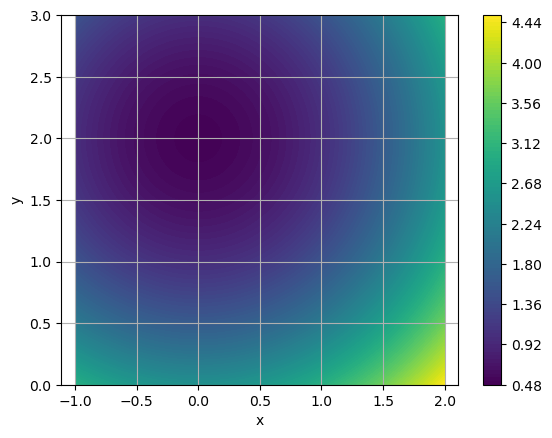

1.4142135623730951


In [143]:
def f_a(x: np.ndarray) -> np.ndarray:
    assert len(x.shape) == 1
    A = np.matrix([[0.5, 0], [0, 0.5]])
    b = np.array([-1, -1])
    c = 1.5
    # print((x.T @ A @ x + b.T @ x + c).flat[0])
    return (x.T @ A @ x + b.T @ x + c).flat[0]


def test_f_a():
    x = np.linspace(-1, 2, 100)
    y = np.linspace(-0, 3, 100)
    xr, yr = np.meshgrid(x, y)
    z = 0 * xr * yr
    for qx, xp in enumerate(x):
        for qy, yp in enumerate(y):
            z[qx, qy] = f_a(np.array([xp, yp]))
    plt.contourf(x, y, z, levels=100)
    plt.grid()
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()
    plt.show()
    print(np.linalg.norm(grad(f_a, np.array([0, 2]))))
    # assert np.isclose(np.linalg.norm(grad(f_a, np.array([0, 1]))), 1.,rtol=1e-2)


test_f_a()

In [146]:
def test_gd():
    def f1(x):
        return np.linalg.norm(x) ** 2

    print(gd_constant_step(f1, np.random.random(1), 0.1))
    assert np.isclose(gd_constant_step(f1, np.random.random(1), 0.1), 0)
    print(gd_fractional_step(f1, np.random.random(1), 0.1))
    assert np.isclose(gd_fractional_step(f1, np.random.random(1), 0.1), 0)
    print(steepest_descent(f1, np.random.random(1), 0.1))
    assert np.isclose(steepest_descent(f1, np.random.random(1), 0.1), 0)
    print(conjugate_gradient(f1, np.random.random(1), 0.1))
    assert np.isclose(conjugate_gradient(f1, np.random.random(1), 0.1), 0)


test_gd()

[1.58842104e-31]
[1.07662126e-31]
[1.17945137e-31]


/tmp/ipykernel_157432/3703390632.py:28: RuntimeWarning: invalid value encountered in scalar divide
  beta = (r1.T @ (r1 - r0) / (r0.T @ r0))


[1.8444556e-31]
